In [2]:
pip install --upgrade fosforml

     |████████████████████████████████| 51kB 5.1MB/s eta 0:00:011
     |████████████████████████████████| 1.9MB 8.4MB/s eta 0:00:01
     |████████████████████████████████| 10.9MB 40.7MB/s eta 0:00:01
     |████████████████████████████████| 38.6MB 62.8MB/s eta 0:00:01
     |████████████████████████████████| 200.3MB 126kB/s s eta 0:00:01                         | 25.7MB 68.6MB/s eta 0:00:03
     |████████████████████████████████| 133kB 103.1MB/s eta 0:00:01
     |████████████████████████████████| 81kB 27.0MB/s eta 0:00:01
     |████████████████████████████████| 1.3MB 65.6MB/s eta 0:00:01
     |████████████████████████████████| 61kB 24.4MB/s eta 0:00:01
     |████████████████████████████████| 98.7MB 308kB/s  eta 0:00:01
     |████████████████████████████████| 51kB 19.5MB/s eta 0:00:01
     |████████████████████████████████| 174kB 102.0MB/s eta 0:00:01
     |████████████████████████████████| 39.9MB 63.6MB/s eta 0:00:01
     |████████████████████████████████| 2.5MB 62.0MB/s eta 0:00:01
    

In [ ]:
pip install seaborn

     |████████████████████████████████| 296kB 6.5MB/s eta 0:00:01


In [3]:
import pandas as pd
import numpy as np
import fosforml
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()

In [4]:
my_session.connection.database

'ASSORTMENT_PLANNING'

In [5]:
my_session.connection.schema

'CPG_BRONZE'

In [6]:
table_name = "ASSORTMENT_PLANNING.CPG_BRONZE.SALES_CLEAN"

In [7]:
sf_df = my_session.sql("select * from {}".format(table_name))

In [8]:
type(sf_df)

snowflake.snowpark.dataframe.DataFrame

In [9]:
df=sf_df.to_pandas()

In [10]:
type(df)

pandas.core.frame.DataFrame

In [16]:
df=df.sort_values(by='TRANS_DATE')

In [20]:
df.head(5)

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND
804225,202309,2023-08-29,2023-08-28,518.18,3,0.001125,518.181818,202209,DB0209,OL32665,Florence,Arizona,City Center,Str1,PRD0059,Perfume and Deodrants,Male Deodrant,Sapphire
765439,202309,2023-08-29,2023-08-28,140.00,16,0.000448,142.857143,202209,DB0209,OL49699,Phoenix,Arizona,Dolphin,Str1,PRD0094,Perfume and Deodrants,Unisex Perfume,Mocha
765438,202309,2023-08-29,2023-08-28,137.14,16,0.000272,142.857143,202209,DB0209,OL48766,Ashland,Kentucky,Dolphin,Str2,PRD0028,Soap,Toilet Soap,Indigo
765437,202309,2023-08-29,2023-08-28,159.09,1,0.000240,159.090909,202209,DB0706,OL160684,Plano,Texas,City Center,Str2,PRD0125,Lotion,Head Lotion,Burgundy
316878,202309,2023-08-29,2023-08-28,52.50,12,0.000132,53.571429,202209,DB0655,OL175633,Puyallup,Washington,Santa Cruz,Str5,PRD0105,Perfume and Deodrants,Female Perfume,Garnet


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 966400 entries, 804225 to 360638
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   MNTH_CODE         966400 non-null  int32  
 1   TRANS_DATE        966400 non-null  object 
 2   START_DATE        966400 non-null  object 
 3   SALES_VALUE       966400 non-null  float64
 4   SALES_UNITS       966400 non-null  int16  
 5   SALES_VOLUME      966400 non-null  float64
 6   SALES_PTR_VALUE   966400 non-null  float64
 7   OC_CODE           966400 non-null  int32  
 8   DISTRIBUTOR_CODE  966400 non-null  object 
 9   OUTLET_CODE       966400 non-null  object 
 10  CITY              966400 non-null  object 
 11  STATE             966400 non-null  object 
 12  COUNTY            966400 non-null  object 
 13  STREET            966400 non-null  object 
 14  PRODUCT_CODE      966400 non-null  object 
 15  CATEGORY          966400 non-null  object 
 16  SUBCATEGORY       96

In [23]:
#Converting into datetime format

df['TRANS_DATE'] = pd.to_datetime(df['TRANS_DATE'])
df['START_DATE'] = pd.to_datetime(df['START_DATE'])

In [25]:
df.shape

(966400, 18)

Clustering the Objects

In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Create additional features
store_features = df.groupby('OUTLET_CODE').agg({
    'SALES_VALUE': ['sum', 'mean'],
    'SALES_UNITS': ['sum', 'mean'],
    'SALES_VOLUME': ['sum', 'mean'],
    'SALES_PTR_VALUE': ['sum', 'mean'],
    'TRANS_DATE': ['count', 'nunique']
}).reset_index()

store_features.columns = ['OUTLET_CODE', 'Total_Sales_Value', 'Avg_Sales_Value', 'Total_Sales_Units', 'Avg_Sales_Units', 'Total_Sales_Volume', 'Avg_Sales_Volume', 'Total_Sales_PTR_Value', 'Avg_Sales_PTR_Value', 'Num_Transactions', 'Sales_Frequency']

# Normalize the features
scaler = StandardScaler()
store_features_scaled = scaler.fit_transform(store_features.drop('OUTLET_CODE', axis=1))

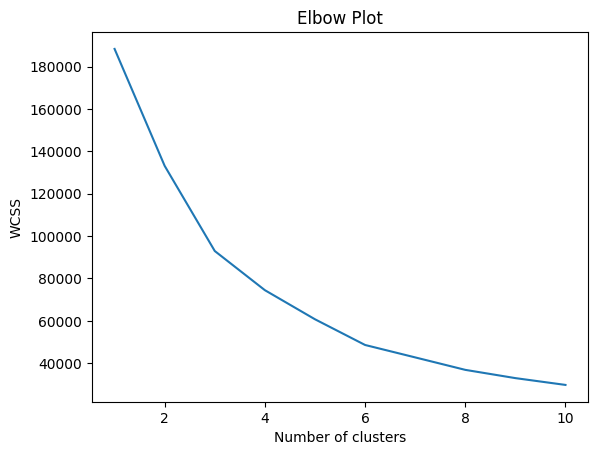

In [27]:
# Determine the optimal number of clusters using the elbow plot
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(store_features_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Plot')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [28]:
# Based on the elbow plot, choose the optimal number of clusters 
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
store_features['Cluster'] = kmeans.fit_predict(store_features_scaled)

In [30]:
# Display the clustered DataFrame
store_features.head()

,OUTLET_CODE,Total_Sales_Value,Avg_Sales_Value,Total_Sales_Units,Avg_Sales_Units,Total_Sales_Volume,Avg_Sales_Volume,Total_Sales_PTR_Value,Avg_Sales_PTR_Value,Num_Transactions,Sales_Frequency,Cluster
0,OL10328,4904.27,144.243235,221,6.500000,0.009587,0.000282,4974.675325,146.313980,34,10,0
1,OL10329,42893.83,219.968359,1148,5.887179,0.072044,0.000369,43805.389611,224.643024,195,37,0
2,OL10330,324169.05,565.740052,3124,5.452007,0.623779,0.001089,331764.545450,578.995716,573,32,1
3,OL10331,12422.54,253.521224,87,1.775510,0.030265,0.000618,12493.636364,254.972171,49,16,0
4,OL10332,36331.30,247.151701,4204,28.598639,0.101504,0.000691,37282.142859,253.620019,147,20,0


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter Plot: Sales Value vs Sales Volume colored by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total_Sales_Value', y='Total_Sales_Volume', hue='Cluster', data=store_features, palette='viridis')
plt.title('Sales Value vs Sales Volume by Cluster')
plt.xlabel('Total Sales Value')
plt.ylabel('Total Sales Volume')
plt.legend(title='Cluster')
plt.show()

ModuleNotFoundError: No module named 'seaborn'